# Discriminative Fine Tuning in Transfer Learning

The purpose of this notebook is to illustrate the implementation of Discriminative Fine Tuning  for Transfer learning
models in Keras. The key idea of Discriminative Fine Tuning (let's call it DFT going foward) is explained by Jeremy Howard and Sebastian Ruder
in their 2018 paper "Universal Language Model Fine-tuning for Text Classification"  https://arxiv.org/pdf/1801.06146.pdf

The fast.ai library comes inbuilt with DFT. I found two implemetations of DFT for Keras in public domain - one for SGD and the other one for Adam. The links for these two are given below:
1) SGD - https://ksaluja15.github.io/Learning-Rate-Multipliers-in-Keras/
2) Adam - https://erikbrorson.github.io/2018/04/30/Adam-with-learning-rate-multipliers/

Both of these integrate nicely with the current Keras version. Thanks to the authors of these two implementations.

For the purpose of this excercise, we will use the data provided by the Kaggle Competition "Histopathologic Cancer Detection". The data for this can be downloaded with a Kaggle account at the following location: https://www.kaggle.com/c/histopathologic-cancer-detection/data


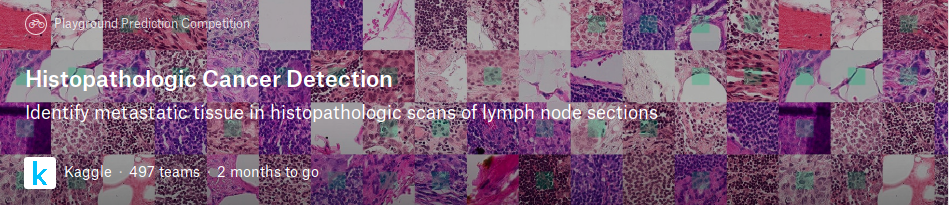

# Getting the house in order

Let's start by getting the house in order first. Let's import all the libraries that we will need for this excercise.

In [64]:
##Importing all the libraries
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import os
import cv2
from scipy import ndimage
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from keras.engine.topology import Layer
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.callbacks import LearningRateScheduler
from keras.applications.xception import Xception 
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras import metrics
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from scipy.misc import imresize
from sklearn.metrics import f1_score as off1
from matplotlib.pyplot import imshow
%matplotlib inline
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

The two public implementations of DFT can be easily imported as packages once we put a blank "__init__.py" file in the relevant folder. In my case the scripts were residing in the folder '/home/sandip/Desktop/Kaggle/histopathological_cancer_detection/pkg'

In [60]:
os.chdir('/home/sandip/Desktop/Kaggle/histopathological_cancer_detection/pkg')
from sgd_cust import LR_SGD
from adam_lr_mult import Adam_lr_mult

For the purpose of this excercise we can start with a relatively moderate image size of (224,224,4) and mini-batch size of 64  

In [2]:
BATCH_SIZE = 64  ## Mini batch size
SEED = 2019      ## Random number seed for reproduceability
SHAPE = (224, 224, 3)
VAL_RATIO = 0.1 # 10 % as validation
DIR = '/home/sandip/Desktop/Kaggle/histopathological_cancer_detection/'

In [5]:
path_to_train = os.path.join(DIR,"train/")
path_to_test = os.path.join(DIR,"test/")
train_labels = pd.read_csv(DIR + "/train_labels.csv")
train_labels['Image'] = train_labels["id"]+".tif"
train_labels.head()

,id,label,Image
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


# Let's Visualize a few images 

In [62]:
sample_img = train_labels.sample(3,axis=0)
sample_img

,id,label,Image
38382,757f32424a40907e2b774c60b1c92496d9d84eb6,1,757f32424a40907e2b774c60b1c92496d9d84eb6.tif
172093,c68c42da33e5fbc8d2a3503fbcbdacc0411c26be,1,c68c42da33e5fbc8d2a3503fbcbdacc0411c26be.tif
191023,a8e3b884102b7a7ec77d4a77cadeaee5115a7c6c,0,a8e3b884102b7a7ec77d4a77cadeaee5115a7c6c.tif


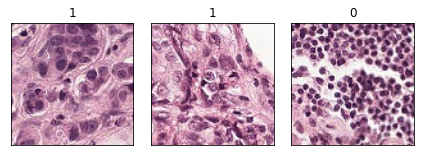

In [65]:
def show_img(sid,img_file, img_title):
    plt.subplot(sid)
    plt.title(img_title)
    plt.xticks([])
    plt.yticks([])
    img = imresize(plt.imread(img_file), (512, 512))
    plt.imshow(img)
img1,label1 = sample_img.iloc[0,2],sample_img.iloc[0,1]
img2,label2 = sample_img.iloc[1,2],sample_img.iloc[1,1]
img3,label3 = sample_img.iloc[2,2],sample_img.iloc[2,1]
show_img(131,os.path.join(path_to_train, img1), label1)
show_img(132,os.path.join(path_to_train, img2), label2)
show_img(133,os.path.join(path_to_train, img3), label3)
plt.tight_layout()
plt.show()

In the images above, the first two images from the left are cases of metastatic cancer cells, whereas the last image on the right is the case where there are no metastatic cancer cells.

In [6]:
nlabls = train_labels['label'].nunique()
nlabls

2

In [7]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels['label']),
                                                 train_labels['label'])
class_weights.shape

(2,)

# Let's set up some helper functions to aid us in running the models

In [8]:
def getTrainDataset():
    
    data = pd.read_csv(DIR + '/train_labels.csv')
    data['Image'] = data["id"]+".tif"
    data['full_path'] = path_to_train + data['Image']
    labels = data['label']
    paths = data['full_path'].tolist()

    return np.array(paths), np.array(labels)
 

def getTestDataset():
    
    data = pd.read_csv(DIR + '/sample_submission.csv')
    data['Image'] = data["id"]+".tif"
    data['full_path'] = path_to_test + data['Image']
    paths = data['full_path'].tolist()
    return np.array(paths)

Keras has inbuilt data generator, but sometimes I prefer using custom versions of data generators as it provides flexibility in how I want to construct and use it.

In [9]:
class CustomDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Dropout(p=(0, 0.2)),
                    iaa.Noop(),
                    iaa.Invert(0.01, per_channel=True),
                    #iaa.AddToHueAndSaturation((-1, 1)),
                    #iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),
                    #iaa.PiecewiseAffine(scale=(0.01, 0.05)), # sometimes move parts of the image around
                    #iaa.ContrastNormalization((0.75, 1.5)),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Sharpen(alpha=0.5),
                    #iaa.Affine(rotate=0),
                    #iaa.Affine(rotate=20),
                    iaa.Affine(rotate=30),
                    iaa.Affine(rotate=45),
                    #iaa.Affine(rotate=60),
                    #iaa.Fliplr(0.5),
                    #iaa.Flipud(0.5),
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image_norm = skimage.io.imread(path)/255.0
        

        im = resize(image_norm, (SHAPE[0], SHAPE[1],SHAPE[2]), mode='reflect')
        return im

This competition tracks area under the ROC curve for leaderboard, let's create a custom function for the same that can be tracked in each epoch.

In [11]:

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value


# Let's start withTransfer Learning

In this example we are using Xception Network for Transfer learning. This was explained in the paper "Xception: Deep Learning with Depthwise Separable Convolutions" by Francois Chollet in his 2017 paper (https://arxiv.org/pdf/1610.02357.pdf). The pretrained network with 'imagenet' weights are available in Keras and one can refer to the documentation for the same here: https://keras.io/applications/#xception

The same idea can easily be adapted to other pre-trained networks. The idea of fine tuning the last few layers in case of Transfer learning (with some great examples) are shown by Francois Chollet in his notebook https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb . Given below is an illustration from Francois Chollet's notebook that illustrates the basic idea behind Transfer learning. The image on the right hand side is illustrates the case when we keep all the layers of pre-trained network frozen and train the network on the new layers that we add.

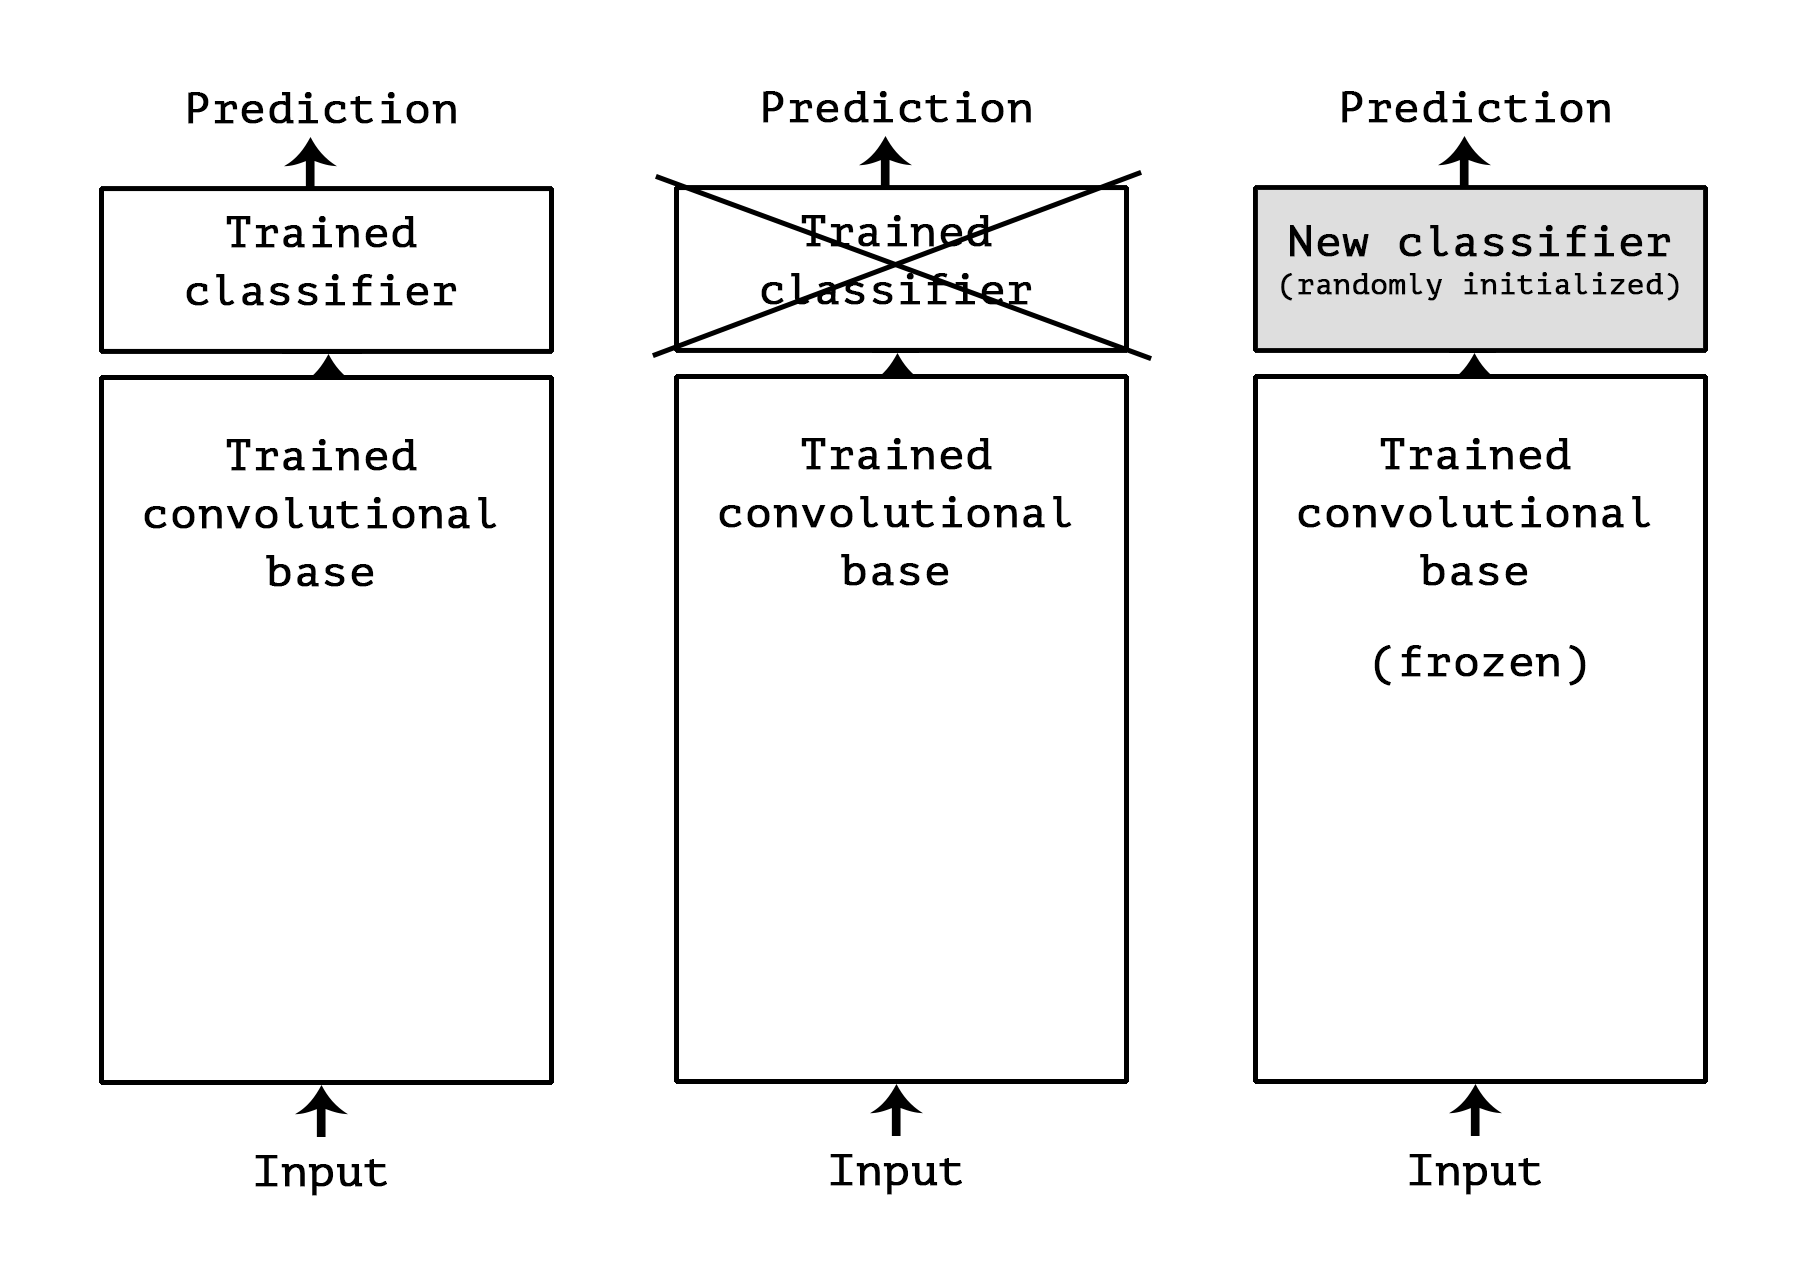
Image Credit:https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

In our case we will be using the concept of fine tuning, where we retrain a few layers of the pre-trained network along with the new layers that we have added on top of that.
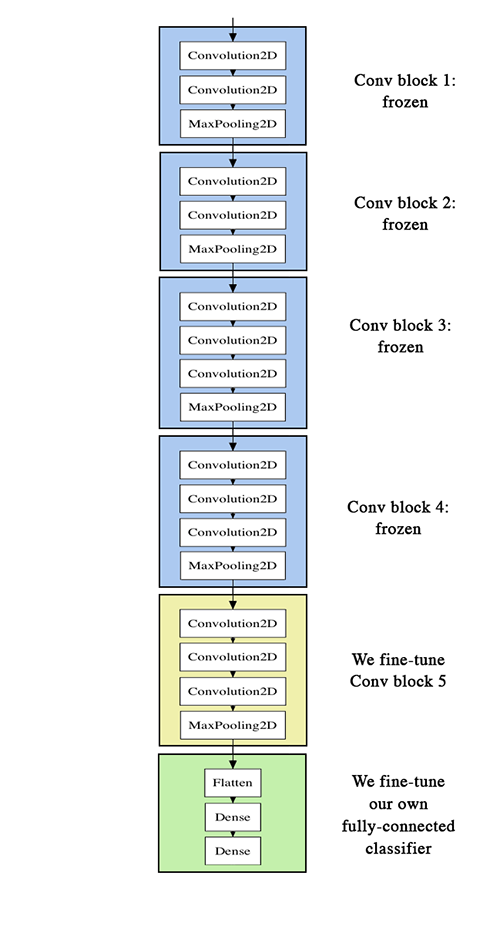

Image Credit: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

In [22]:
def create_model(input_shape, n_out):
    inp = Input(input_shape)
    pretrain_model = Xception(include_top=False, weights='imagenet', input_tensor=inp)
    x = pretrain_model.output
    ##We add our own layers on top of the pre-trained model output from this point onwards
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(n_out, activation="sigmoid")(x)
    x = Dropout(0.25)(x)
    x = Dense(n_out-1, activation="sigmoid")(x)
    ## In this section we set the last few layers of the pre-trained network to be re-trained for our case  
    
    for layer in pretrain_model.layers[:97]:
        layer.trainable = False
    ### Comment out the last two lines and uncomment the lines below if you want to fine tune the network for
    ####only the last few layers that we have added
    #for layer in pretrain_model.layers:
        #layer.trainable = False
        
    return Model(inp, x)

# Setting up Discriminative Fine Tuning

Here we set up the factors for each of layers in the network that will be applied on the base learning rate. In other words, if base[lr] denotes the learning rate for the entire network then learning rate of a layer k is defined k[lr] = base[lr] * multiplicative factor.

The core idea is that the initial layers of a network contain much finer features like, edge, lines, curves etc. We would not want to change the weights of the pretrained network too much in these layers (most of these networks are trained on 'imagenet' data that probably has the largest collection of labelled data). 

In the last few layers of the network we essentially combine the lower level features i.e. lines, curves, edges to come up with higher level features like circle with a certain shade, ellipse with texture or in case of human features (nose, ear, face) etc. This is where we would like to change the weights from their initial  problem statement and make them specific to our classification problem.

In [14]:
lrm={}
lrm['block1_conv1']=1
lrm['block1_conv1_bn']=1
lrm['block1_conv1_act']=1
lrm['block1_conv2']=1
lrm['block1_conv2_bn']=1
lrm['block1_conv2_act']=1
lrm['block2_sepconv1']=1
lrm['block2_sepconv1_bn']=1
lrm['block2_sepconv2_act']=1
lrm['block2_sepconv2']=1
lrm['block2_sepconv2_bn']=1
lrm['conv2d_1']=1
lrm['block2_pool']=1
lrm['batch_normalization_1']=1
lrm['add_1']=1
lrm['block3_sepconv1_act']=1
lrm['block3_sepconv1']=1
lrm['block3_sepconv1_bn']=1
lrm['block3_sepconv2_act']=1
lrm['block3_sepconv2']=1
lrm['block3_sepconv2_bn']=1
lrm['conv2d_2']=1
lrm['block3_pool']=1
lrm['batch_normalization_2']=1
lrm['add_2']=1
lrm['block4_sepconv1_act']=1
lrm['block4_sepconv1']=1
lrm['block4_sepconv1_bn']=1
lrm['block4_sepconv2_act']=1
lrm['block4_sepconv2']=1
lrm['block4_sepconv2_bn']=1
lrm['conv2d_3']=1
lrm['block4_pool']=1
lrm['batch_normalization_3']=1
lrm['add_3']=1
lrm['block5_sepconv1_act']=1
lrm['block5_sepconv1']=1
lrm['block5_sepconv1_bn']=1
lrm['block5_sepconv2_act']=1
lrm['block5_sepconv2']=1
lrm['block5_sepconv2_bn']=1
lrm['block5_sepconv3_act']=1
lrm['block5_sepconv3']=1
lrm['block5_sepconv3_bn']=1
lrm['add_4']=1
lrm['block6_sepconv1_act']=1
lrm['block6_sepconv1']=1
lrm['block6_sepconv1_bn']=1
lrm['block6_sepconv2_act']=1
lrm['block6_sepconv2']=1
lrm['block6_sepconv2_bn']=1
lrm['block6_sepconv3_act']=1
lrm['block6_sepconv3']=1
lrm['block6_sepconv3_bn']=1
lrm['add_5']=1
lrm['block7_sepconv1_act']=1
lrm['block7_sepconv1']=1
lrm['block7_sepconv1_bn']=1
lrm['block7_sepconv2_act']=1
lrm['block7_sepconv2']=1
lrm['block7_sepconv2_bn']=1
lrm['block7_sepconv3_act']=1
lrm['block7_sepconv3']=1
lrm['block7_sepconv3_bn']=1
lrm['add_6']=1
lrm['block8_sepconv1_act']=1
lrm['block8_sepconv1']=1
lrm['block8_sepconv1_bn']=1
lrm['block8_sepconv2_act']=1
lrm['block8_sepconv2']=1
lrm['block8_sepconv2_bn']=1
lrm['block8_sepconv3_act']=1
lrm['block8_sepconv3']=1
lrm['block8_sepconv3_bn']=1
lrm['add_7']=1
lrm['block9_sepconv1_act']=1
lrm['block9_sepconv1']=0.001
lrm['block9_sepconv1_bn']=0.001
lrm['block9_sepconv2_act']=0.001
lrm['block9_sepconv2']=0.001
lrm['block9_sepconv2_bn']=0.001
lrm['block9_sepconv3_act']=0.001
lrm['block9_sepconv3']=0.001
lrm['block9_sepconv3_bn']=0.001
lrm['add_8']=0.001
lrm['block10_sepconv1_act']=0.01
lrm['block10_sepconv1']=0.01
lrm['block10_sepconv1_bn']=0.01
lrm['block10_sepconv2_act']=0.01
lrm['block10_sepconv2']=0.01
lrm['block10_sepconv2_bn']=0.01
lrm['block10_sepconv3_act']=0.01
lrm['block10_sepconv3']=0.01
lrm['block10_sepconv3_bn']=0.01
lrm['add_9']=0.01
lrm['block11_sepconv1_act']=0.01
lrm['block11_sepconv1']=0.01
lrm['block11_sepconv1_bn']=0.01
lrm['block11_sepconv2_act']=0.01
lrm['block11_sepconv2']=0.01
lrm['block11_sepconv2_bn']=0.01
lrm['block11_sepconv3_act']=0.01
lrm['block11_sepconv3']=0.01
lrm['block11_sepconv3_bn']=0.01
lrm['add_10']=0.1
lrm['block12_sepconv1_act']=0.1
lrm['block12_sepconv1']=0.1
lrm['block12_sepconv1_bn']=0.1
lrm['block12_sepconv2_act']=0.1
lrm['block12_sepconv2']=0.1
lrm['block12_sepconv2_bn']=0.1
lrm['block12_sepconv3_act']=0.1
lrm['block12_sepconv3']=0.1
lrm['block12_sepconv3_bn']=0.1
lrm['add_11']=1
lrm['block13_sepconv1_act']=1
lrm['block13_sepconv1']=1
lrm['block13_sepconv1_bn']=1
lrm['block13_sepconv2_act']=1
lrm['block13_sepconv2']=1
lrm['block13_sepconv2_bn']=1
lrm['conv2d_4']=1
lrm['block13_pool']=1
lrm['batch_normalization_4']=1
lrm['add_12']=1
lrm['block14_sepconv1']=1
lrm['block14_sepconv1_bn']=1
lrm['block14_sepconv1_act']=1
lrm['block14_sepconv2']=1
lrm['block14_sepconv2_bn']=1
lrm['block14_sepconv2_act']=1
lrm['global_average_pooling2d_1']=1
lrm['dropout_1']=1
lrm['dense_1']=1


In [23]:
## We show the example of Adam, the method can be be used for SGD by looking at the commented out portions
base_lr = 0.0001
#momentum = 0.9
#decay = 0.01
#optimizer = LR_SGD(lr=base_lr, momentum=momentum, decay=0.0001, nesterov=False,multipliers = lrm)
optimizer = Adam_lr_mult(lr=base_lr,multipliers = lrm)
sess = tf.Session()
with sess.graph.as_default():
    model = create_model(input_shape=SHAPE, n_out=nlabls)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc',auc_roc])
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [24]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization_5
15 add_13
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_6
25 add_14
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_7
35 add_15
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_16
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

# Training the model

In [25]:
paths, labels = getTrainDataset()

In [26]:
# dividing into Training and Validation splits for evaluation at the end of each epoch
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]

pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

(220025,) (220025,)
(198022,) (198022,) (22003,) (22003,)


In [27]:
tg = CustomDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=False, augment = True, shuffle = True)
vg = CustomDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=False,augment = False, shuffle = True)

In [29]:
epochs = 2
use_multiprocessing = True 
workers = 1 
base_cnn = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    #validation_steps=8,
    #class_weight = class_weights,
    epochs=epochs,
    #callbacks =[clr],
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1)

Epoch 1/2
3095/3095 [==============================] - 4775s 2s/step - loss: 0.6103 - acc: 0.8074 - auc_roc: 0.7958 - val_loss: 0.5516 - val_acc: 0.8749 - val_auc_roc: 0.8172
Epoch 2/2
3095/3095 [==============================] - 4784s 2s/step - loss: 0.5383 - acc: 0.8398 - auc_roc: 0.8224 - val_loss: 0.4841 - val_acc: 0.8837 - val_auc_roc: 0.8266


In [30]:
model.save(DIR + 'HistCancerDetect_XceptionNet_DFT_224_224_3_v0.h5')
model.load_weights(DIR + 'HistCancerDetect_XceptionNet_DFT_224_224_3_v0.h5')

# Warm restarts

This is loosely borrowed from the idea of 'Warm Restarts' explained by Ruder. To quote Ruder "The restart is warm as the optimization does not start from scratch but from the parameters to which the model converged during the last step". Here we just reload the previous model and start training it again. You may choose to lower/increase the base learning (as we do in the next block of training) to replicate the ideas explained the Ruder. You can find the details of 'Warm Restarts' in the following resources:

1) http://ruder.io/deep-learning-optimization-2017/index.html#warmrestarts

2) https://arxiv.org/pdf/1608.03983.pdf

In [31]:
epochs = 6
use_multiprocessing = True 
workers = 1 
base_cnn = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    #validation_steps=8,
    #class_weight = class_weights,
    epochs=epochs,
    #callbacks =[clr],
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1)

Epoch 1/6
3095/3095 [==============================] - 4733s 2s/step - loss: 0.4877 - acc: 0.8467 - auc_roc: 0.8302 - val_loss: 0.4306 - val_acc: 0.8901 - val_auc_roc: 0.8339
Epoch 2/6
3095/3095 [==============================] - 4713s 2s/step - loss: 0.4492 - acc: 0.8515 - auc_roc: 0.8372 - val_loss: 0.3886 - val_acc: 0.8987 - val_auc_roc: 0.8409
Epoch 3/6
3095/3095 [==============================] - 4747s 2s/step - loss: 0.4183 - acc: 0.8557 - auc_roc: 0.8450 - val_loss: 0.3606 - val_acc: 0.9019 - val_auc_roc: 0.8495
Epoch 4/6
3095/3095 [==============================] - 4719s 2s/step - loss: 0.3940 - acc: 0.8580 - auc_roc: 0.8539 - val_loss: 0.3354 - val_acc: 0.9053 - val_auc_roc: 0.8580
Epoch 5/6
3095/3095 [==============================] - 4718s 2s/step - loss: 0.3761 - acc: 0.8598 - auc_roc: 0.8615 - val_loss: 0.3213 - val_acc: 0.9087 - val_auc_roc: 0.8647
Epoch 6/6
3095/3095 [==============================] - 4735s 2s/step - loss: 0.3601 - acc: 0.8637 - auc_roc: 0.8676 - val_los

In [32]:
model.save(DIR + 'HistCancerDetect_XceptionNet_DFT_224_224_3_v1.h5')
model.load_weights(DIR + 'HistCancerDetect_XceptionNet_DFT_224_224_3_v1.h5')

In [33]:
base_lr = 0.00001
momentum = 0.9
#optimizer = LR_SGD(lr=base_lr, momentum=momentum, decay=0.0001, nesterov=False,multipliers = lrm)
optimizer = Adam_lr_mult(lr=base_lr,multipliers = lrm)
with sess.graph.as_default():
    model = create_model(input_shape=SHAPE, n_out=nlabls)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc',auc_roc])
model.load_weights(DIR + 'HistCancerDetect_XceptionNet_DFT_224_224_3_v1.h5')

In [34]:
epochs = 1
use_multiprocessing = True # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
base_cnn = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    #validation_steps=8,
    #class_weight = class_weights,
    epochs=epochs,
    #callbacks =[clr],
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1)

Epoch 1/1
3095/3095 [==============================] - 4788s 2s/step - loss: 0.3463 - acc: 0.8697 - auc_roc: 0.9164 - val_loss: 0.3056 - val_acc: 0.9113 - val_auc_roc: 0.9182


In [35]:
model.save(DIR + 'HistCancerDetect_XceptionNet_DFT_224_224_3_v2.h5')
model.load_weights(DIR + 'HistCancerDetect_XceptionNet_DFT_224_224_3_v2.h5')

As we can see that our validation accuracy is substaintially high 91% accuracy and ~ 92% Area under the ROC curves. With higher image size and learning rate optimization one may be able to achieve even higher accuracy  number.

# Generate Predictions on the Test Set (Optional - only for Kaggle submissions)

In [36]:
pathsTest= getTestDataset()

In [39]:
test_labels = np.zeros((pathsTest.shape[0],nlabls))
testg = CustomDataGenerator(pathsTest, test_labels, BATCH_SIZE, SHAPE)
submit = pd.read_csv(DIR + '/sample_submission.csv')
test_labels.shape

(57458, 2)

In [48]:
P = np.zeros((pathsTest.shape[0], 1))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = model.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

100%|██████████| 898/898 [07:35<00:00,  1.97it/s]


In [51]:
pred_ = pd.DataFrame(P)

In [57]:
submission = pd.concat([submit.iloc[:,0],pred_], axis=1)
submission =submission.rename(columns={ submission.columns[1]: "label" })
submission.head(10)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.165612
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.165579
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.165520
3,2c35657e312966e9294eac6841726ff3a748febf,0.191176
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.165959
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0.987115
6,aa0307865281d4484ddf8c637c348292968b93a7,0.165520
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0.987114
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0.165520
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0.632776


In [59]:
submission.to_csv(DIR + "XceptionNet_DiscriminativeFineTuning_01292019.csv", index=False)

The submission with minimal tweaks and learning rate optimization is able to achieve 0.8975 of Area under the ROC curve score on public leaderboard (which used 49% of the test data). The validation ROC score is quite consistent with what we had observed in our validation auc as well. 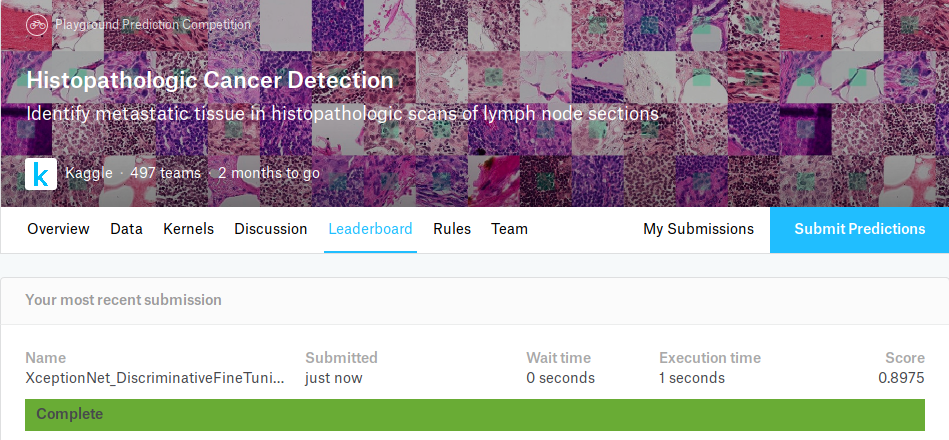

More could be acheived with trying other pre-trained network architectures, hyper-parameter optimization and even ensembling to get even higher scores.